<a href="https://colab.research.google.com/github/wilberquito/AMLProject/blob/main/notebooks/Resnet34.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Resnet34


In [1]:
import zipfile
from pathlib import Path
import torch
import matplotlib.pyplot as plt

In [2]:
try:
    import google.colab
    IN_COLAB = True
    ! pip install torchvision
    ! pip install torchinfo
except:
    IN_COLAB = False

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [16]:
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')

    !rm -rf data
    data_path = Path('/content/drive/MyDrive/AML/dataset_CIFAR10.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall("data")

    !rm -rf modular
    data_path = Path('/content/drive/MyDrive/AML/modular.zip')
    with zipfile.ZipFile(data_path,"r") as zip_ref:
        zip_ref.extractall(".")

    !rm -rf trained
    !cp -rf /content/drive/MyDrive/AML/trained ./trained

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Show device available

In [4]:
'cuda' if torch.cuda.is_available() else 'cpu'

'cuda'

## Show model arquitecture

In [5]:
from torchinfo import summary
import modular.models as models
from prettytable import PrettyTable

In [6]:
amlresnet34 = models.AMLResnet34(out_dim=10)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 209MB/s]


In [7]:
batch_size = 16
img_size = 232
summary(model=amlresnet34, 
        input_size=(32, 3, img_size, img_size),
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

/usr/local/lib/python3.9/dist-packages/torchinfo/torchinfo.py:477: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  action_fn=lambda data: sys.getsizeof(data.storage()),
/usr/local/lib/python3.9/dist-packages/torch/storage.py:665: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return super().__sizeof__() + self.nbytes()


Layer (type (var_name))                       Input Shape          Output Shape         Param #              Trainable
AMLResnet34 (AMLResnet34)                     [32, 3, 232, 232]    [32, 10]             --                   Partial
├─ResNet (net)                                [32, 3, 232, 232]    [32, 512]            --                   False
│    └─Conv2d (conv1)                         [32, 3, 232, 232]    [32, 64, 116, 116]   (9,408)              False
│    └─BatchNorm2d (bn1)                      [32, 64, 116, 116]   [32, 64, 116, 116]   (128)                False
│    └─ReLU (relu)                            [32, 64, 116, 116]   [32, 64, 116, 116]   --                   --
│    └─MaxPool2d (maxpool)                    [32, 64, 116, 116]   [32, 64, 58, 58]     --                   --
│    └─Sequential (layer1)                    [32, 64, 58, 58]     [32, 64, 58, 58]     --                   False
│    │    └─BasicBlock (0)                    [32, 64, 58, 58]     [32, 64, 58, 

In [9]:
def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: 
            continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params}")
    return total_params
    
_ = count_parameters(amlresnet34)

+-------------+------------+
|   Modules   | Parameters |
+-------------+------------+
| fc.1.weight |    512     |
|  fc.1.bias  |    512     |
| fc.3.weight |   262144   |
|  fc.3.bias  |    512     |
| fc.5.weight |    512     |
|  fc.5.bias  |    512     |
| fc.7.weight |    5120    |
|  fc.7.bias  |     10     |
+-------------+------------+
Total Trainable Params: 269834


## Fine tunning

In [10]:
import torch
import modular.datasets as datasets
import modular.models as models 
from pathlib import Path
from modular.engine import train
import torchvision.transforms as transforms
from modular.utils import set_seeds

set_seeds(seed=42)

# Model
amlresnet34 = models.AMLResnet34(out_dim=10)
# Let base train
amlresnet34.freeze_base()

train_transforms, validate_transforms = amlresnet34.transforms, amlresnet34.transforms

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(),
])

train_transforms = transforms.Compose([augmentation, train_transforms])

# Optimizer
lr = 0.005
optimizer = torch.optim.SGD(params=amlresnet34.parameters(),
                             lr=lr)

# Criterion
criterion = torch.nn.CrossEntropyLoss()

# Number of epochs to train the model
epochs = 3

# Default device to train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Where the model is saved
save_as = Path('finetune.amlresnet34.pth')

# Mini batch
batch_size=100

train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=train_transforms,
                                           batch_size=batch_size,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                           transformer=validate_transforms,
                                           batch_size=batch_size,
                                           suffle=False)

In [11]:
results = train(model=amlresnet34,
                train_dataloader=train_dataloader,
                test_dataloader=validate_dataloader,
                optimizer=optimizer,
                criterion=criterion,
                epochs=epochs,
                device=device,
                save_as=save_as)

  0%|          | 0/3 [00:00<?, ?it/s]

0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 1 | train_loss: 2.1308 | train_acc: 0.2378 | test_loss: 1.6279 | test_acc: 0.4693


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 2 | train_loss: 1.8404 | train_acc: 0.3476 | test_loss: 1.4646 | test_acc: 0.5088


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Epoch: 3 | train_loss: 1.7643 | train_acc: 0.3752 | test_loss: 1.4089 | test_acc: 0.5275


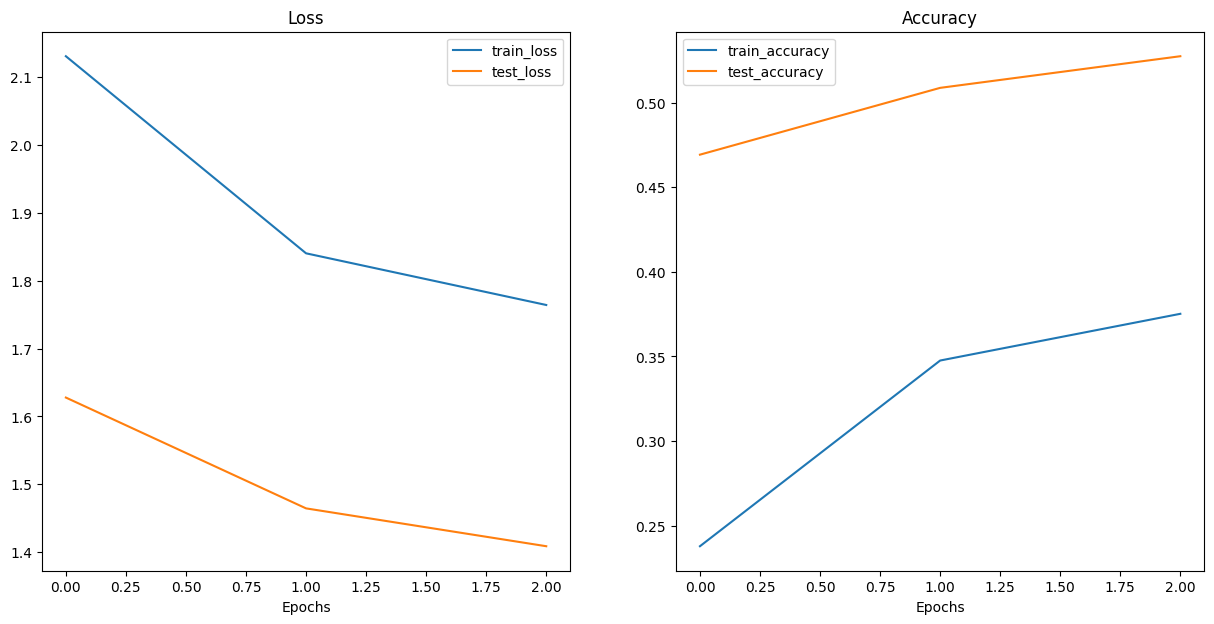

In [12]:
from modular.utils import plot_loss_curves
plot_loss_curves(results)

In [13]:
if IN_COLAB:
  from google.colab import files
  files.download('finetune.amlresnet34.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Training find tunning AMLResnet34

In [14]:
try:
    import google.colab
    IN_COLAB = True
    ! pip install torchvision
    ! pip install torchinfo
except:
    IN_COLAB = False

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [17]:
import torch
from pathlib import Path

saved_data = torch.load(Path('trained/finetune.amlresnet34.pth'))
saved_data.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc', 'epoch', 'optimizer', 'model'])

In [20]:
import torch
import modular.datasets as datasets
import modular.models as models 
from pathlib import Path
from modular.engine import train
import torchvision.transforms as transforms
from modular.utils import set_seeds

set_seeds(seed=42)

# Model
amlresnet34 = models.AMLResnet34(out_dim=10)
# Recover state dict
state_dict = saved_data['model']
# Load saved state dict into the model
amlresnet34.load_state_dict(state_dict)
# Freeze base
amlresnet34.unfreeze_base()

train_transforms, validate_transforms = amlresnet34.transforms, amlresnet34.transforms

augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.RandomPerspective(),
])

train_transforms = transforms.Compose([augmentation, train_transforms])

# Optimizer
lr = 0.001
optimizer = torch.optim.SGD(params=amlresnet34.parameters(),
                             lr=lr)

# Criterion
criterion = torch.nn.CrossEntropyLoss()

# Number of epochs to train the model
epochs = 10

# Default device to train model
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)

# Where the model is saved
save_as = Path('amlresnet34.pth')

# Mini batch
batch_size=750

train_dataloader = datasets.get_dataloader(folder_root='data/train',
                                           transformer=train_transforms,
                                           batch_size=batch_size,
                                           suffle=True)
validate_dataloader = datasets.get_dataloader(folder_root='data/validation',
                                           transformer=validate_transforms,
                                           batch_size=batch_size,
                                           suffle=False)

In [21]:
results = train(model=amlresnet34,
                train_dataloader=train_dataloader,
                test_dataloader=validate_dataloader,
                optimizer=optimizer,
                criterion=criterion,
                epochs=epochs,
                device=device,
                save_as=save_as)

  0%|          | 0/10 [00:00<?, ?it/s]

0it [00:00, ?it/s]

OutOfMemoryError: ignored

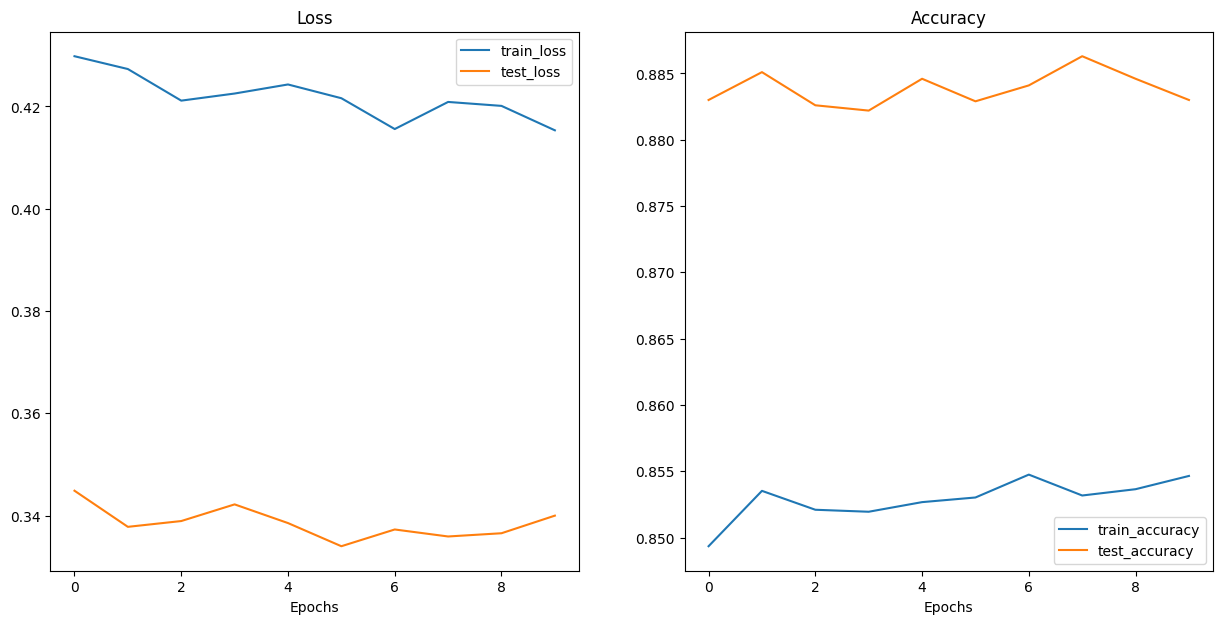

In [ ]:
from modular.utils import plot_loss_curves
plot_loss_curves(results)

In [ ]:
if IN_COLAB:
  from google.colab import files
  files.download('amlresnet101.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>